## Model fitting and evaluation

### Linear Regresssion

In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from scipy import stats
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import joblib
import pickle
#Loading dataset
data = pd.read_csv('data/healthdata.csv')


## Data exploration

In [2]:
#Checking for the column names in the dataset.
print(data.columns)

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')


In [3]:
#Calculating average age and BMI of individuals in the dataset.
print(f"Average age: {data['age'].mean().astype(int)}\nAverage BMI: {data['bmi'].mean().round(2)}")

Average age: 39
Average BMI: 30.66


In [4]:
#Determining counts of each smokers and non-smokers.
counts = data['smoker'].value_counts()
#Determining their percentages
percentage_counts = ((counts/len(data)) * 100).round(2)
print(f"counts\n{counts}")
print(f"Percentage counts \n {percentage_counts}")

counts
smoker
no     1064
yes     274
Name: count, dtype: int64
Percentage counts 
 smoker
no     79.52
yes    20.48
Name: count, dtype: float64


In [5]:
#Finding minimum, median and maximum values of insurance charges
print(f"Minimum:{data['charges'].min()}\nMedian:{data['charges'].median()}\nMaximum:{data['charges'].max()}")

Minimum:1121.8739
Median:9382.033
Maximum:63770.42801


## Data Visualizations

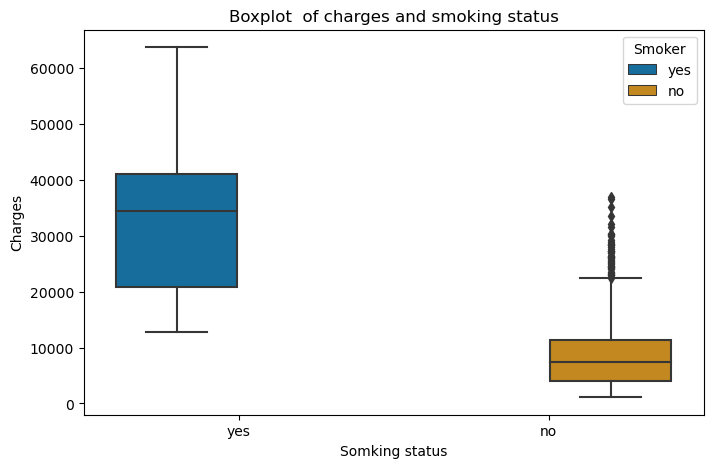

In [77]:
#Boxplot of smoker and charges
plt.figure(figsize = (8,5))
sns.boxplot(y = "charges", x = "smoker" , data = data, hue = "smoker", palette = "colorblind")
plt.title("Boxplot  of charges and smoking status")
plt.xlabel("Somking status")
plt.ylabel("Charges")
plt.legend().set_title("Smoker")

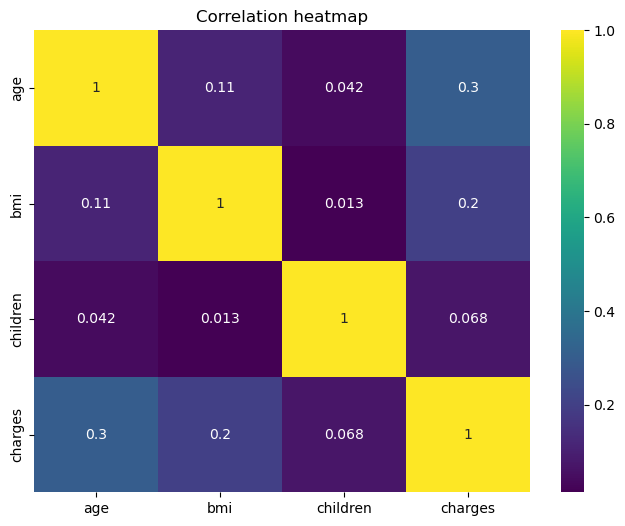

In [78]:
plt.figure(figsize=(8,6) , dpi = 100)
correlation = (data.drop(['sex','smoker','region'], axis = 1)).corr()
sns.heatmap(correlation, annot=True, cmap="viridis")
plt.title('Correlation heatmap')
plt.show()


### Feature engineering

In [6]:
#Converting smoker to binary values 1 for smoking = Yes and 0 for not smoking = No
def smoker_conversion(variable):
    if variable == "yes":
        return 1
    else:
        return 0
    
data['smoker'] = data['smoker'].apply(smoker_conversion)


In [9]:
#categorizing individuals into 'Young' (18-35), 'Middle-aged' (36-55), and 'Senior' (56+), then calculate the average charges for each age group.
def age_converter(age):
    if age >= 18 | age<=35:
        return "Young"
    elif age >= 36 | age<=55:
        return "Middle-aged"
    else:
        return "Senior"

data["age_group"] = data["age"].apply(age_converter)
#Creating a variable named bmi_smoker which is a product of smoker and bmi
data['bmi_smoker'] = data['bmi'] *data['smoker']
#Creating a variable named age_smoker which is a product of age and smoker.
data['age_smoker'] = data['age'] * data['smoker']
#Creating a variable named children age_bmi which is a product of age and bmi
data['age_bmi'] = data['age'] * data['bmi']
#Creating a variable named children_per_age which divides the number of children by age
data['children_per_age'] = data['children']/data['age']


#### Explanation for the above variables
I had to create the above 4 variables in order to capture the interactions that might compound some effects on charges.

## Model building and evaluation
### Fitting a linear regresssion model

In [10]:
# Define features and target variable
X = data.drop('charges', axis=1)
y = data['charges']

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['age', 'bmi', 'children','bmi_smoker','age_smoker','age_bmi','children_per_age']),
        ('cat', OneHotEncoder(drop='first'), ['age_group','sex', 'smoker', 'region'])
    ]
)

# Apply preprocessing to features
X_processed = preprocessor.fit_transform(X)


In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

Training set size: (1070, 14)
Testing set size: (268, 14)


In [13]:
model = LinearRegression()
model.fit(X_train, y_train)

# Display model coefficients and intercept
print("Model Coefficients:", model.coef_)
print("Model Intercept:", model.intercept_)

Model Coefficients: [ 3.32761626e+03 -2.16906993e+02 -1.23427163e+02  1.87113535e+04
  7.24785278e+01  7.54879935e+02  7.72476462e+02  2.03649953e+01
  3.62489230e+02 -5.54573134e+02 -2.13714180e+04 -5.89635552e+02
 -9.42169517e+02 -1.22420619e+03]
Model Intercept: 18607.15378314592


In [14]:
# Make predictions on test set
y_pred = model.predict(X_test)

# Evaluate performance using R² and RMSE
r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
#Function to calculate adjusted R2
def adjusted_r2(r2_calc):
    n = len(y_test)  # Number of observations
    p = X.shape[1]  # Number of predictors
    adjusted_r2 = 1 - ((1 - r2_calc) * (n - 1) / (n - p - 1))
    return adjusted_r2

print(f"Linear model R² Score: {r2:.3f}")
print(f"Linear model RMSE:{rmse:.2f}")
r2_adj = adjusted_r2(r2)
print(f"linear model adjusted R2: {r2_adj:.3f}")

Linear model R² Score: 0.865
Linear model RMSE:4577.96
linear model adjusted R2: 0.859


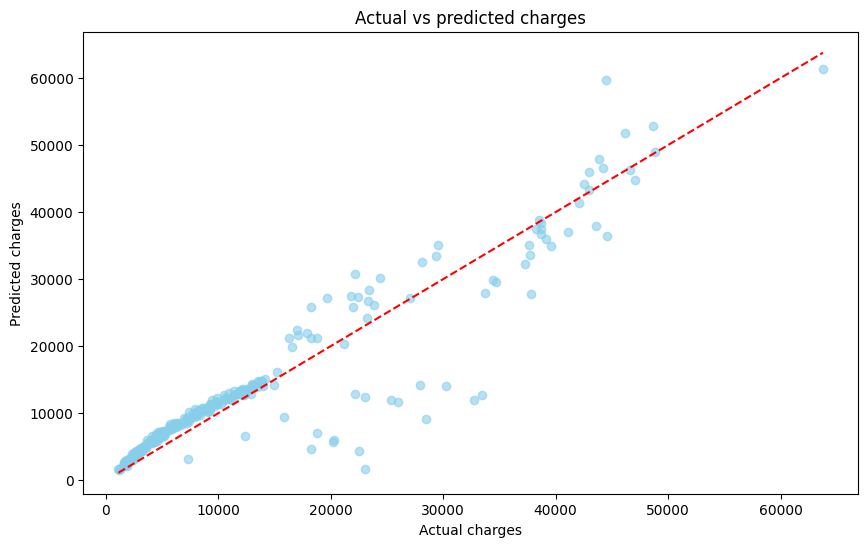

In [ ]:
#Plotting actual vs predicted charges
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='skyblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Reference line (y=x)
plt.xlabel('Actual charges')
plt.ylabel('Predicted charges')
plt.title('Actual vs predicted charges')
plt.show()

### Fitting a random forest regressor

In [ ]:
#Initializing Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=100, #Number of trees
    max_depth=None, #Depth of each tree (None = full depth)
    random_state=42
)

#Fitting the model
rf_model.fit(X_train, y_train)

#Making predictions
y_pred = rf_model.predict(X_test)

#Evaluating the model
RMSE = mean_squared_error(y_test, y_pred, squared = False)
R2 = r2_score(y_test, y_pred)

rf_predictions = rf_model.predict(X_test)
RMSE = mean_squared_error(y_test, rf_predictions, squared = False)
R2 = r2_score(y_test, rf_predictions)
print(f"Base Random Forest Model RMSE: {RMSE:.2f}")
print(f"Base Random Forest model R2: {R2:.2f}")
r2_adj = adjusted_r2(R2)
print(f"Base Random Forest model adjusted R2: {r2_adj:.3f}")

Base Random Forest Model RMSE: 4509.22
Base Random Forest model R2: 0.87
Base Random Forest model adjusted R2: 0.863


### Hyperparameter tuning for the random forest model

In [ ]:
#Defining parameter grid
param_grid = {
    'n_estimators': [10,100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap':[True,False]
}

rf = RandomForestRegressor(random_state=42)

#GridSearch Search
grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid,
    cv=5, 
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose = 0
    )
grid_search.fit(X_train, y_train)
predictions = grid_search.predict(X_test)
mse = mean_squared_error(y_test , predictions, squared = False)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best R² score: {grid_search.best_score_}")

c:\Users\user\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
810 fits failed out of a total of 2430.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
810 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\user\anaconda3\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\user\anaconda3\Lib\site-packages\s

Mean Squared Error (MSE): 4338.73
Best parameters: {'bootstrap': True, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best R² score: -21681491.684596043


The best parameters for our model are:

'bootstrap': True

'max_depth': 10

'max_features': 'sqrt'

'min_samples_leaf': 4

'min_samples_split': 10 

'n_estimators': 100

#### Fitting the tuned (optimal) new RF model

In [17]:
final_model = RandomForestRegressor(
    bootstrap = True,
    max_depth = 10,
    max_features = 'sqrt',
    min_samples_leaf = 4,
    min_samples_split= 10, 
    n_estimators = 100
)
final_model.fit(X_train, y_train)
final_model.feature_importances_

array([0.05970419, 0.05277862, 0.00634238, 0.34167963, 0.22595219,
       0.06540286, 0.01357413, 0.00256715, 0.01019322, 0.00320327,
       0.21227623, 0.00173863, 0.00257558, 0.00201193])

In [18]:
predictions = final_model.predict(X_test)
RMSE = mean_squared_error(y_test, predictions, squared = False)
R2 = r2_score(y_test, predictions)
print(f"Tuned Random Forest Model RMSE: {RMSE:.2f}")
print(f"Tuned Random Forest model R2: {R2:.2f}")
r2_adj = adjusted_r2(R2)
print(f"Tuned Random Forest model adjusted R2: {r2_adj:.3f}")   

Tuned Random Forest Model RMSE: 4285.51
Tuned Random Forest model R2: 0.88
Tuned Random Forest model adjusted R2: 0.877


##### Plotting feature importances for the tuned model

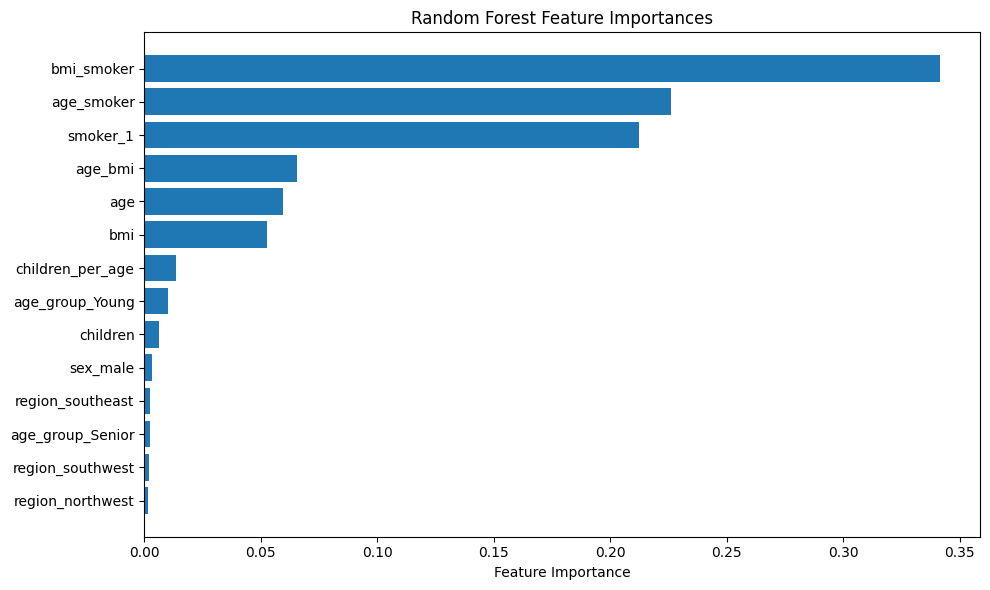

In [ ]:
#Getting numeric features and categorical features from the original data.
numeric_features = ['age', 'bmi', 'children', 'bmi_smoker', 'age_smoker', 'age_bmi', 'children_per_age']
categorical_features = ['age_group', 'sex', 'smoker', 'region']
#Accessing OneHotEncoder from the fitted preprocessor
ohe = preprocessor.named_transformers_['cat']
encoded_cat_features = ohe.get_feature_names_out(categorical_features)
all_feature_names = list(numeric_features) + list(encoded_cat_features)
importances = final_model.feature_importances_
assert len(importances) == len(all_feature_names), "Mismatch between importances and feature names"
feature_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(feature_df['Feature'], feature_df['Importance'])
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()

### Fitting Light GBM regressor

In [91]:
#Initializing lightGBM regressor
lgbm_model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    verbose = -1
)
#Fitting the model
lgbm_model.fit(X_train, y_train)
#Making predictions and evaluation
y_pred_lgbm = lgbm_model.predict(X_test)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm , squared = False)
r2_lgbm = r2_score(y_test, y_pred_lgbm)
print(f"LightGBM RMSE: {mse_lgbm:.2f}")
print(f"LightGBM R²: {r2_lgbm:.2f}")
r2_adj = adjusted_r2(r2_lgbm)
print(f"light gbm model adjusted R2: {r2_adj:.3f}")

LightGBM RMSE: 4400.60
LightGBM R²: 0.88
light gbm model adjusted R2: 0.870


### Fitting XGBoost model

In [92]:
# Initialize XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)
#Fitting the model
xgb_model.fit(X_train, y_train)
#Predictions and evaluation
y_pred_xgb = xgb_model.predict(X_test)
mse_xgb = mean_squared_error(y_test, y_pred_xgb, squared = False)
r2_xgb = r2_score(y_test, y_pred_xgb)
print(f"XGBoost MSE: {mse_xgb:.2f}")
print(f"XGBoost R²: {r2_xgb:.2f}")
r2_adj = adjusted_r2(r2_xgb)
print(f"linear model adjusted R2: {r2_adj:.3f}")

XGBoost MSE: 4442.12
XGBoost R²: 0.87
linear model adjusted R2: 0.867


From the above models the optimized Random forest model is the best because it has a lower RMSE of 4315.11 and a higher adjusted R2 score of 0.875.

#### Saving tuned RandomForest model

In [26]:
with open("final_model.pkl", "wb") as file:
    pickle.dump(final_model, file)

with open("preprocessor.pkl", "wb") as file:
    pickle.dump(preprocessor, file)


In [27]:
model = joblib.load("utils/final_model.pkl")
preprocessor = joblib.load("utils/preprocessor.pkl")
type(model)
type(preprocessor)

sklearn.compose._column_transformer.ColumnTransformer